In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("Housing_dataset_train.csv")
test = pd.read_csv("Housing_dataset_test.csv")
sub = pd.read_csv("Sample_submission.csv")
#var = pd.read_csv("VariableDefinitions.csv")

In [3]:
train

ID       loc                 title  bedroom  bathroom  \
0       3583   Katsina  Semi-detached duplex      2.0       2.0   
1       2748      Ondo             Apartment      NaN       2.0   
2       9261     Ekiti                   NaN      7.0       5.0   
3       2224   Anambra       Detached duplex      5.0       2.0   
4      10300      Kogi        Terrace duplex      NaN       5.0   
...      ...       ...                   ...      ...       ...   
13995   6175       Edo              Bungalow      NaN       7.0   
13996   9704    Kaduna             Apartment      NaN       7.0   
13997  11190   Plateau              Bungalow      8.0       6.0   
13998   9256     Delta                  Flat      NaN       6.0   
13999   8787  Nasarawa                   NaN      9.0       7.0   

       parking_space        price  
0                1.0  1149999.565  
1                4.0  1672416.689  
2                NaN  3364799.814  
3                4.0  2410306.756  
4                6.0  2600700.898  
...              ...          ...  
13995            NaN  2367927.861  
13996            5.0  2228516.471  
13997            5.0  2406812.693  
13998            1.0  3348918.718  
13999            5.0  2858516.890  

[14000 rows x 7 columns]

In [4]:
train[train['price'] > 0].reset_index(drop = True)

ID       loc                 title  bedroom  bathroom  \
0       3583   Katsina  Semi-detached duplex      2.0       2.0   
1       2748      Ondo             Apartment      NaN       2.0   
2       9261     Ekiti                   NaN      7.0       5.0   
3       2224   Anambra       Detached duplex      5.0       2.0   
4      10300      Kogi        Terrace duplex      NaN       5.0   
...      ...       ...                   ...      ...       ...   
13995   6175       Edo              Bungalow      NaN       7.0   
13996   9704    Kaduna             Apartment      NaN       7.0   
13997  11190   Plateau              Bungalow      8.0       6.0   
13998   9256     Delta                  Flat      NaN       6.0   
13999   8787  Nasarawa                   NaN      9.0       7.0   

       parking_space        price  
0                1.0  1149999.565  
1                4.0  1672416.689  
2                NaN  3364799.814  
3                4.0  2410306.756  
4                6.0  2600700.898  
...              ...          ...  
13995            NaN  2367927.861  
13996            5.0  2228516.471  
13997            5.0  2406812.693  
13998            1.0  3348918.718  
13999            5.0  2858516.890  

[14000 rows x 7 columns]

In [5]:
train.describe()

ID       bedroom      bathroom  parking_space         price
count  14000.000000  12201.000000  12195.000000   12189.000000  1.400000e+04
mean    4862.700357      4.308171      3.134235       3.169825  2.138082e+06
std     3818.348214      2.441165      2.035950       1.599415  1.083057e+06
min        0.000000      1.000000      1.000000       1.000000  4.319673e+05
25%     1672.750000      2.000000      1.000000       2.000000  1.393990e+06
50%     3527.000000      4.000000      2.000000       3.000000  1.895223e+06
75%     8011.250000      6.000000      5.000000       4.000000  2.586699e+06
max    12999.000000      9.000000      7.000000       6.000000  1.656849e+07

In [6]:
test.head()

ID      loc                 title  bedroom  bathroom  parking_space
0    845     Kano             Penthouse        4         1              2
1   1924  Adamawa             Apartment        2         2              4
2  10718  Adamawa              Bungalow        2         7              2
3  12076    Lagos               Mansion        9         5              2
4  12254    Gombe  Semi-detached duplex        5         6              1

In [7]:
train.title.unique()

array(['Semi-detached duplex', 'Apartment', nan, 'Detached duplex',
       'Terrace duplex', 'Mansion', 'Bungalow', 'Penthouse', 'Townhouse',
       'Flat', 'Cottage'], dtype=object)

In [8]:
data = train.drop(["price"], axis=1).append(test)
data.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
dtype: int64

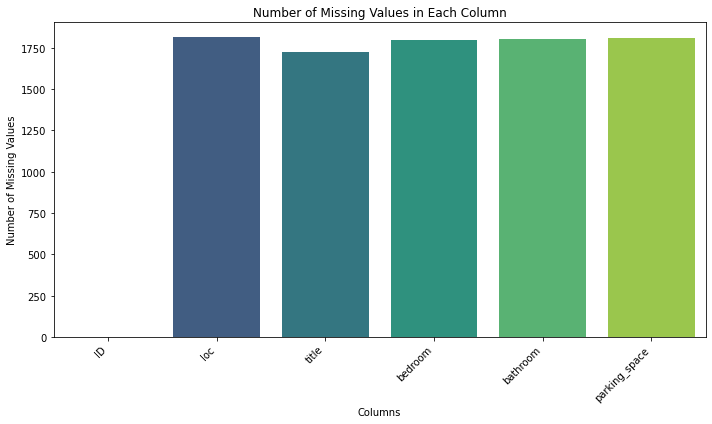

In [9]:
# Calculate the number of missing values in each column
missing_values_count = data.isnull().sum()

# Create a colorful bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values_count.index, y=missing_values_count.values, palette='viridis')

# Set plot properties
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [10]:
# Define the ranking based on size (arranged from smallest to biggest)
house_type_ranks = {
"Apartment":1,
"Flat":2,
"Cottage":3,
"Semi-detached duplex":4,
"Terrace duplex":5,
"Bungalow":6,
"Townhouse":7,
"Detached duplex":8,
"Penthouse":9,
"Mansion":10,
}



# Map the house types to numerical values based on size ranking
data['title'] = data['title'].map(house_type_ranks)

# Print the updated dataframe
data.head()


ID      loc  title  bedroom  bathroom  parking_space
0   3583  Katsina    4.0      2.0       2.0            1.0
1   2748     Ondo    1.0      NaN       2.0            4.0
2   9261    Ekiti    NaN      7.0       5.0            NaN
3   2224  Anambra    8.0      5.0       2.0            4.0
4  10300     Kogi    5.0      NaN       5.0            6.0

In [11]:
# Complete the mapping of states to integers
state_to_int = {
    'Lagos': 1,
    'Kano': 2,
    'Oyo': 3,
    'Kaduna': 4,
    'Rivers': 5,
    'Delta': 6,
    'Ogun': 7,
    'Ibadan': 8,
    'Enugu': 9,
    'Ekiti': 10,
    'Anambra': 11,
    'Kogi': 12,
    'Kwara': 13,
    'Benue': 14,
    'Plateau': 15,
    'Edo': 16,
    'Ondo': 17,
    'Akwa Ibom': 18,
    'Osun': 19,
    'Bauchi': 20,
    'Niger': 21,
    'Adamawa': 22,
    'Kebbi': 23,
    'Sokoto': 24,
    'Abia': 25,
    'Cross River': 26,
    'Yobe': 27,
    'Zamfara': 28,
    'Ebonyi': 29,
    'Imo': 30,
    'Jigawa': 31,
    'Taraba': 32,
    'Bayelsa': 33,
    'Nassarawa': 34,
    'Gombe': 35,
    'Borno': 36
}

# Assuming you have a DataFrame called 'data' with a column named 'state'

# Map the 'state' column to integers using the defined mapping
data['loc'] = data['loc'].map(state_to_int)

# Display the updated DataFrame with the new 'state_int' column
data.head()


ID   loc  title  bedroom  bathroom  parking_space
0   3583   NaN    4.0      2.0       2.0            1.0
1   2748  17.0    1.0      NaN       2.0            4.0
2   9261  10.0    NaN      7.0       5.0            NaN
3   2224  11.0    8.0      5.0       2.0            4.0
4  10300  12.0    5.0      NaN       5.0            6.0

In [12]:
data = data.drop("ID", axis=1)

In [13]:
data.isnull().sum()

loc              2854
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
dtype: int64

In [14]:
train.shape[0]

14000

In [15]:
X = data[:train.shape[0]]
y = train.price
test_df = data[train.shape[0]:]

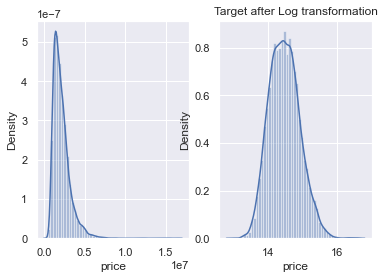

In [16]:
sns.set()
y_transformed = pd.Series(np.log1p(y))

fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])
plt.title("Target after Log transformation")
# ax[0].axvline(y_transformed)
sns.distplot(y_transformed, ax=ax[1])
plt.show()

In [17]:
model = CatBoostRegressor(n_estimators=100)
model.fit(X, y)

Learning rate set to 0.403894
0:	learn: 897788.2991000	total: 179ms	remaining: 17.7s
1:	learn: 799617.0120947	total: 194ms	remaining: 9.51s
2:	learn: 724624.7289456	total: 201ms	remaining: 6.51s
3:	learn: 683157.7498030	total: 209ms	remaining: 5.02s
4:	learn: 662543.7718642	total: 215ms	remaining: 4.09s
5:	learn: 639671.8436757	total: 220ms	remaining: 3.45s
6:	learn: 628019.3280488	total: 225ms	remaining: 2.99s
7:	learn: 600238.7590396	total: 231ms	remaining: 2.65s
8:	learn: 590733.0794476	total: 237ms	remaining: 2.39s
9:	learn: 586820.5894940	total: 243ms	remaining: 2.19s
10:	learn: 582375.5880656	total: 250ms	remaining: 2.02s
11:	learn: 576950.7638300	total: 255ms	remaining: 1.87s
12:	learn: 573016.7091506	total: 261ms	remaining: 1.75s
13:	learn: 570665.6764716	total: 268ms	remaining: 1.64s
14:	learn: 561351.6017801	total: 274ms	remaining: 1.55s
15:	learn: 559862.8490242	total: 278ms	remaining: 1.46s
16:	learn: 558544.5309048	total: 284ms	remaining: 1.39s
17:	learn: 554506.8084353	to

Text(0.5, 1.0, 'CatboostRegressor features importance (top):')

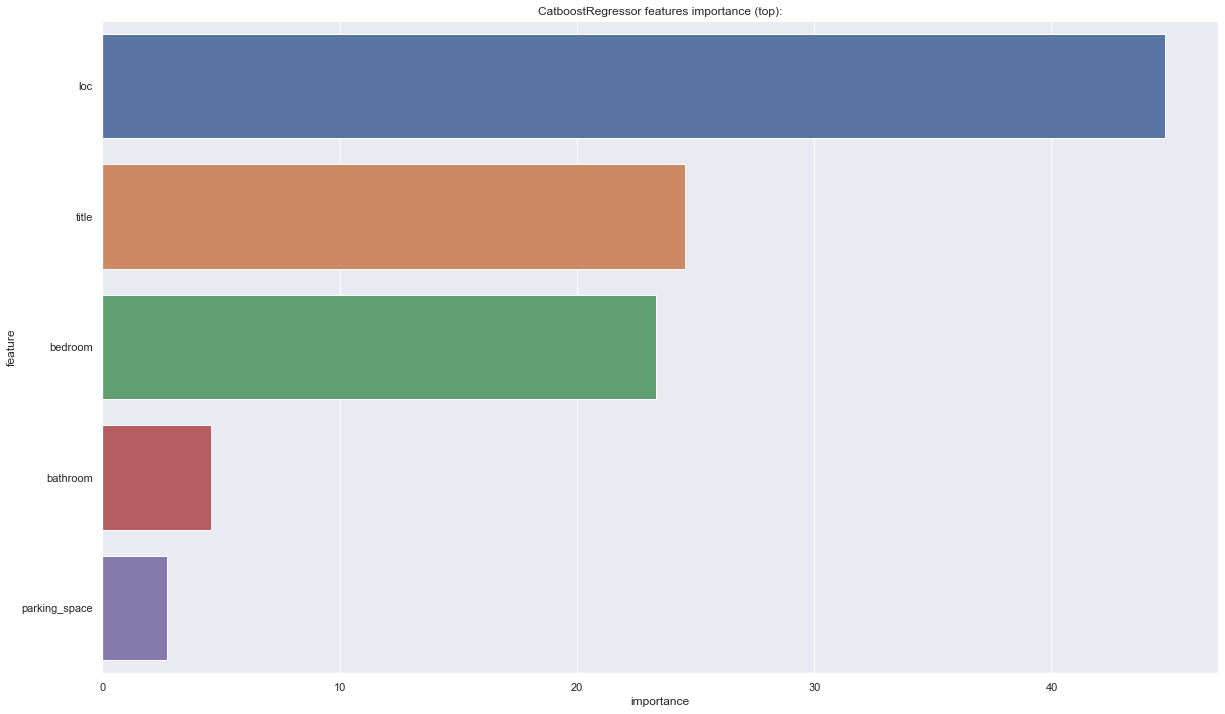

In [19]:
# # 0.7831404345536787
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatboostRegressor features importance (top):')

In [20]:
import joblib
joblib.dump(model, "catboost_model.pkl")

['catboost_model.pkl']